In [ ]:
%matplotlib notebook
%load_ext autoreload
from glob import glob
from skimage import io
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.get_backend()
import joblib as jb
import seaborn as sns
import palettable.colorbrewer as cb
sns.set_palette('colorblind')
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook
from datetime import timedelta
import palettable.cmocean as ocean
from __future__ import unicode_literals
import os
import IPython.display as display
#matplotlib.rcParams['backend'] = 'TkAgg' 
from sklearn import metrics

## Data Dimension

In [8]:
image_size=48
image_size_flat=image_size*image_size
image_shape=(image_size,image_size)
# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
num_classes = 6

## Convolutional Network Architecture

In [9]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
dc_size = 128   

## Generate Filenames for Plots

In [10]:
def gen_seq_fname(ext='pdf',count_file='count.dat',reset_count='False'):
    if reset_count =='True':
        count =0
    else:    
        count = jb.load('count.dat') 
    str1='{}.{}'.format(count,ext)
    count +=1
    jb.dump(count,'count.dat')
    return str1

In [11]:
mod_label_dict={0:['Angry',u'\U0001f620'],1:['Fear',u'\U0001f628'],\
            2:['Happy',u'\U0001f604'],3:['Sad',u'\U0001f622'],4:['Surprise',u'\U0001f632'],\
            5:['Neutral',u'\U0001f610']}

## Plot Images [Helper Functions]

In [12]:
def plot_images(images, cls_true, cls_pred=None,save_fig='False'):
    assert len(images) == len(cls_true) == 16
    
    #true_label=[mod_label_dict[i][1] for i in np.argmax(cls_true,axis=1)]
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(4, 4,figsize=(10,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    if cls_pred is None:
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(48,-1), cmap='gray')
        label_color='blue'
        true_=np.argmax(cls_true[i])
        if cls_pred is None:
            xlabel = "{} : {}".format(mod_label_dict[true_][0],mod_label_dict[true_][1])
        else:
            
            pred_=np.argmax(cls_pred[i])
            xlabel = "{0} : {1}".\
            format(mod_label_dict[true_][0], mod_label_dict[pred_][0])
            
    
            if true_ != pred_:
                label_color='red'
        
        ax.set_xlabel(xlabel,color=label_color,fontname='DejaVu Sans',fontsize=20)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout()
    if save_fig == 'True':
        f=gen_seq_fname()
        fig.savefig(f)
        print('Saved as {}'.format(f))
    

## Generate weights and biases 

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [14]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [15]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [16]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    
    
    return layer

## Placeholder variables

In [19]:
tf.reset_default_graph()
x = tf.placeholder("float", shape=[None, image_size_flat],\
                   name='x')
image_x = tf.reshape(x, \
                   [-1,image_size,image_size,\
                    num_channels])
y=tf.placeholder("float",\
                      shape=[None,num_classes],\
                       name='y')
tf.add_to_collection('vars', x)
tf.add_to_collection('vars', y)

## Convolutional Layer 1

In [20]:
#tf.reset_default_graph()
L1_conv, W1_conv=\
new_conv_layer(input = image_x,\
               num_input_channels=num_channels,\
               filter_size=filter_size1,
               num_filters=num_filters1,
               use_pooling=True)

print(L1_conv)
print(W1_conv)

Tensor("Relu:0", shape=(?, 24, 24, 16), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>


## Convolutional Layer 2

In [21]:
L2_conv, W2_conv=\
new_conv_layer(input = L1_conv,\
               num_input_channels=num_filters1,\
               filter_size=filter_size2,
               num_filters=num_filters2,
               use_pooling=True)

print(L2_conv)
print(W2_conv)

Tensor("Relu_1:0", shape=(?, 12, 12, 36), dtype=float32)
<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>


## Prepare for Densely Connected Layer [ Flatten Input For DL]

In [22]:
L_flat, num_features = flatten_layer(L2_conv)
print(L_flat)
print(num_features)

Tensor("Reshape_1:0", shape=(?, 5184), dtype=float32)
5184


## Densely Connected Layer 1

In [23]:
L1_dc = new_fc_layer(input=L_flat,
                         num_inputs=num_features,
                         num_outputs=dc_size,
                         use_relu=True)
L1_dc

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

## Densely Connected Layer 2

In [24]:
L2_dc = new_fc_layer(input=L1_dc,
                         num_inputs=dc_size,
                         num_outputs=num_classes,
                         use_relu=False)
L2_dc

<tf.Tensor 'add_3:0' shape=(?, 6) dtype=float32>

## Prediction 

In [25]:
y_pred=tf.nn.softmax(L2_dc)
print(y_pred)

Tensor("Softmax:0", shape=(?, 6), dtype=float32)


In [ ]:
#y_pred_val=tf.argmax(y_pred,dimension=1)
#print(y_pred_val)

## Cost-Function For Optimization

In [26]:
cross_entropy = \
tf.nn.softmax_cross_entropy_with_logits(\
                                        logits=L2_dc,
                                        labels=y)

cost=tf.reduce_mean(cross_entropy)

In [27]:
# optimizer = tf.train.AdamOptimizer(\
#                                    learning_rate=1e-4).minimize(cost)
optimizer=tf.train.RMSPropOptimizer(0.0005, 0.9).minimize(cost)

In [28]:
# correct_pred=tf.equal(y_true_val,y_pred_val)
# accuracy1=tf.reduce_mean(tf.cast(correct_pred,tf.float32))
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


## TensorFlow Session



In [29]:
session = tf.Session()
saver = tf.train.Saver(max_to_keep=10000)


In [31]:
saver.restore(sess=session,save_path='1stmodel_checkpoints_2/1stmodel_1080_5516.0')

INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_1080_5516.0


In [ ]:
# def optimistic_restore(session, save_file):
#     reader = tf.train.NewCheckpointReader(save_file)
#     saved_shapes = reader.get_variable_to_shape_map()
#     var_names = sorted([(var.name, var.name.split(':')[0]) for var in tf.global_variables()
#         if var.name.split(':')[0] in saved_shapes])
#     restore_vars = []
#     name2var = dict(zip(map(lambda x:x.name.split(':')[0], tf.global_variables()), tf.global_variables()))
#     with tf.variable_scope('', reuse=True):
#         for var_name, saved_var_name in var_names:
#             curr_var = name2var[saved_var_name]
#             var_shape = curr_var.get_shape().as_list()
#             if var_shape == saved_shapes[saved_var_name]:
#                 restore_vars.append(curr_var)
#     saver = tf.train.Saver(restore_vars)
#     saver.restore(session, save_file)

## Ensemble Models
From the previous notebook First Convolutional Neural Net-fv.ipynb, I save the model every 1000 iterations and to see how ensemble approach works, we will pick the almost all model with accuracy higher than 60% and predict on the test dataset and add prediction of all models together. Then, we will select the category by the highest score. Each model will pedict the categories by giving the probabilistic score between 0-1 for six categories and we will select the categories which gain most probabilistic score. In some cases, people assume some models work better therefore, the prediction is multiplied by a weight before summation. Here, I assume all the models give the accuracy around 61% and so I don't apply any weight to any model. All models are treated equally without biases.

In [33]:
model_list=[i[:-6] for i in glob('1stmodel_checkpoints_2/*.index')]
model_list

['1stmodel_checkpoints_2/1stmodel_1080_5516.0',
 '1stmodel_checkpoints_2/1stmodel_2160_5997.0',
 '1stmodel_checkpoints_2/1stmodel_3240_5904.0',
 '1stmodel_checkpoints_2/1stmodel_4320_6317.0',
 '1stmodel_checkpoints_2/1stmodel_5400_6233.0',
 '1stmodel_checkpoints_2/1stmodel_6480_6112.0',
 '1stmodel_checkpoints_2/1stmodel_7560_6120.0',
 '1stmodel_checkpoints_2/1stmodel_8640_6183.0',
 '1stmodel_checkpoints_2/1stmodel_9720_6183.0',
 '1stmodel_checkpoints_2/1stmodel_10800_6230.0']

### Reimport previous test dataset

In [42]:
testset=jb.load('test_dataset.pkl')
test_y=testset['test_y']
test_x=testset['test_x']

In [49]:
total_val_y=np.zeros((len(model_list[:-1]),*test_y.shape))
for count,i in enumerate(model_list[:-1]):
    saver.restore(sess=session,save_path=i)
    total_val_y[count]=session.run(y_pred, feed_dict={x: test_x})

INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_1080_5516.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_2160_5997.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_3240_5904.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_4320_6317.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_5400_6233.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_6480_6112.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_7560_6120.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_8640_6183.0
INFO:tensorflow:Restoring parameters from 1stmodel_checkpoints_2/1stmodel_9720_6183.0


In [50]:
ens_y=total_val_y.mean(axis=0)

In [51]:
accuracy(validation_y,test_y)

63.885088919288648

In [37]:
def plot_confusion_matrix(predictions, y_test,classes,
                          normalize=False,
                          title='Confusion matrix',
                          #cmap=cb.diverging.RdYlBu_11_r.mpl_colormap):
                          cmap=cb.sequential.YlGn_9.mpl_colormap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Compute confusion matrix
    predictions=np.argmax(predictions,1)
    y_test=np.argmax(y_test,1)
    cm = metrics.confusion_matrix(y_test, predictions)
    np.set_printoptions(precision=2)
    fig, ax1 = plt.subplots()    
    
    if normalize:
        np.set_printoptions(precision=2)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print("Normalized confusion matrix")
        cm=np.round(cm,2)
    else:
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print('Confusion matrix, without normalization')
        
    
    
    plt.title(title)
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)




<IPython.core.display.Javascript object>


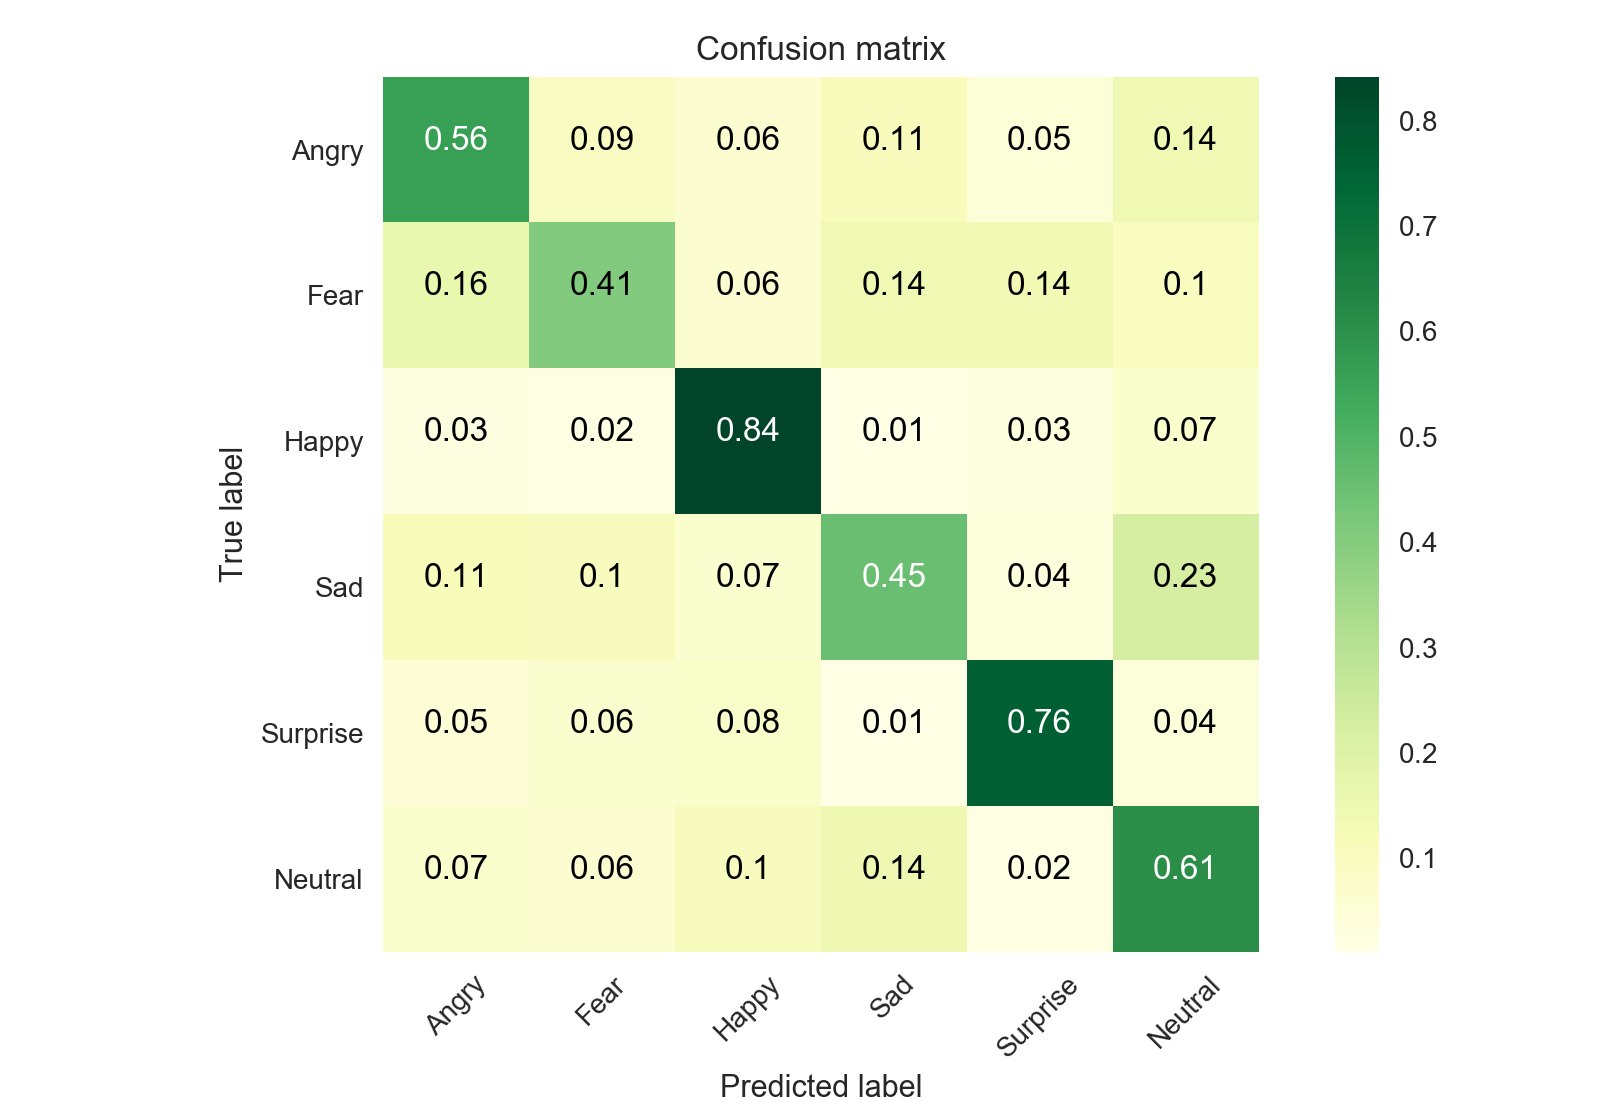

Normalized confusion matrix


In [56]:
plot_confusion_matrix(ens_y,test_y,np.array(list(mod_label_dict.values()))[:,0],\
                     normalize=True)
plt.savefig('Images/Ensemble.png',dpi=900)